In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
from utilities1 import *
from imbalance_gain import *
from imbalance_gain1 import *

In [ ]:
def analyze_rossler_causality(data_dir, tau=20):
    """
    Analyze Rössler data with varying epsilon values to find optimal alphas for X→Y and Y→X causality.
    
    Parameters:
    -----------
    data_dir : str
        Directory containing the Rössler data files
    tau : int
        Time delay for causality analysis
    """
    # Get list of data files and sort them
    data_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".p")])
    
    # Initialize results dictionary
    results = {
        'epsilon': [],
        'xy_alpha_method1': [],
        'yx_alpha_method1': [],
        'xy_alpha_method2': [],
        'yx_alpha_method2': []
    }
    
    
    alphas = np.linspace(0, 1, 50)
    
    for data_file in data_files:
        try:
           
            epsilon = float(data_file.split("_")[-1].replace(".p", ""))  
            results['epsilon'].append(epsilon)
            
            print(f"Processing file with epsilon={epsilon:.2f}")
            
            # Load data
            file_path = os.path.join(data_dir, data_file)
            with open(file_path, 'rb') as f:
                trajectory = pickle.load(f)
            
           
            traj_length = trajectory.shape[0]

            n_points = 2500
            sample_times = np.linspace(0,traj_length-tau-1,n_points,dtype=int)
            k = 5
            n_jobs = 4

            # Get data at time t and t+tau
            X0 = trajectory[sample_times, 1:4]
            Y0 = trajectory[sample_times, 4:]
            
            # Method 1: Original utilities and imbalance_gain
            try:
                rank_matrix_Xtau = compute_rank_matrix(trajectory[sample_times + tau,1:4])
                rank_matrix_Ytau = compute_rank_matrix(trajectory[sample_times + tau,4:])
                
                info_imbalances_xy_method1 = scan_alphas(cause_present=X0, effect_present=Y0, rank_matrix_effect_future=rank_matrix_Ytau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
                info_imbalances_yx_method1 = scan_alphas(cause_present=Y0, effect_present=X0, rank_matrix_effect_future=rank_matrix_Xtau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
                

                imbalance_gain_X_to_Y, index_optimal_alpha_X_to_Y = compute_imbalance_gain(info_imbalances_xy_method1)
                imbalance_gain_Y_to_X, index_optimal_alpha_Y_to_X = compute_imbalance_gain(info_imbalances_yx_method1)
            

                results['xy_alpha_method1'].append(alphas[index_optimal_alpha_X_to_Y])
                results['yx_alpha_method1'].append(alphas[index_optimal_alpha_Y_to_X])
                
            except Exception as e:
                print(f"Error with Method 1: {e}")
                results['xy_alpha_method1'].append(np.nan)
                results['yx_alpha_method1'].append(np.nan)
            
            # Method 2: utilities1 and imbalance_gain1
            try:
                rank_matrix_Xtau1 = compute_rank_matrix_a(trajectory[sample_times + tau,1:4])
                rank_matrix_Ytau1 = compute_rank_matrix_a(trajectory[sample_times + tau,4:])
                
                
                info_imbalances_xy_method2 = scan_alphas_a(cause_present=X0, effect_present=Y0, rank_matrix_effect_future=rank_matrix_Ytau1, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
                info_imbalances_yx_method2 = scan_alphas_a(cause_present=Y0, effect_present=X0, rank_matrix_effect_future=rank_matrix_Xtau1, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")

                imbalance_gain_X_to_Y, index_optimal_alpha_X_to_Y1 = compute_imbalance_gain(info_imbalances_xy_method2)
                imbalance_gain_Y_to_X, index_optimal_alpha_Y_to_X1 = compute_imbalance_gain(info_imbalances_yx_method2)

                results['xy_alpha_method2'].append(alphas[index_optimal_alpha_X_to_Y1])
                results['yx_alpha_method2'].append(alphas[index_optimal_alpha_Y_to_X1])
                
            except Exception as e:
                print(f"Error with Method 2: {e}")
                results['xy_alpha_method2'].append(np.nan)
                results['yx_alpha_method2'].append(np.nan)
                
        except Exception as e:
            print(f"Error processing file {data_file}: {e}")
    
    
    sorted_indices = np.argsort(results['epsilon'])
    for key in results:
        results[key] = [results[key][i] for i in sorted_indices]
    
    return results

def print_and_plot_results(results):
    """
    Print and plot the results of the analysis.
    """

    print("\nResults from Method 1 (original utilities and imbalance_gain):")
    print("Epsilon\tOptimal Alpha X→Y\tOptimal Alpha Y→X")
    for i in range(len(results['epsilon'])):
        print(f"{results['epsilon'][i]:.2f}\t{results['xy_alpha_method1'][i]:.2f}\t{results['yx_alpha_method1'][i]:.2f}")
    
    print("\nResults from Method 2 (utilities1 and imbalance_gain1):")
    print("Epsilon\tOptimal Alpha X→Y\tOptimal Alpha Y→X")
    for i in range(len(results['epsilon'])):
        print(f"{results['epsilon'][i]:.2f}\t{results['xy_alpha_method2'][i]:.2f}\t{results['yx_alpha_method2'][i]:.2f}")
    
    plt.figure(figsize=(12, 8)) 


    plt.plot(results['epsilon'], results['xy_alpha_method1'], 'b-o', label='X→Y (Method 1)', linewidth=2)
    plt.plot(results['epsilon'], results['yx_alpha_method1'], 'r-o', label='Y→X (Method 1)', linewidth=2)
    plt.plot(results['epsilon'], results['xy_alpha_method2'], 'b--s', label='X→Y (Method 2)', linewidth=2)
    plt.plot(results['epsilon'], results['yx_alpha_method2'], 'r--s', label='Y→X (Method 2)', linewidth=2)

    plt.xlabel('Coupling Strength (ε)', fontsize=14)
    plt.ylabel('Optimal Alpha', fontsize=14)
    plt.title('Comparison of Optimal Alpha Values vs Coupling Strength', fontsize=16)

    plt.legend(fontsize=12, loc='best')
    plt.grid(True)
    plt.tight_layout()

  
    plt.savefig('optimal_alphas_vs_epsilon_combined.png', dpi=300)
    plt.show()



In [14]:
def main():
    data_dir = "rossler_data_eps_range"
    results = analyze_rossler_causality(data_dir)
    print_and_plot_results(results)

Processing file with epsilon=0.00
Processing file with epsilon=0.05
Processing file with epsilon=0.10
Processing file with epsilon=0.15
Processing file with epsilon=0.20
Processing file with epsilon=0.25
Processing file with epsilon=0.30
Processing file with epsilon=0.35
Processing file with epsilon=0.40
Processing file with epsilon=0.45
Processing file with epsilon=0.50
Processing file with epsilon=0.55
Processing file with epsilon=0.60
Processing file with epsilon=0.65
Processing file with epsilon=0.70
Processing file with epsilon=0.75
Processing file with epsilon=0.80
Processing file with epsilon=0.85
Processing file with epsilon=0.90
Processing file with epsilon=0.95
Processing file with epsilon=1.00

Results from Method 1 (original utilities and imbalance_gain):
Epsilon	Optimal Alpha X→Y	Optimal Alpha Y→X
0.00	0.00	0.00
0.05	0.02	0.02
0.10	0.08	0.00
0.15	0.14	0.00
0.20	0.20	0.02
0.25	0.35	0.02
0.30	0.53	0.00
0.35	0.41	0.02
0.40	0.76	0.02
0.45	0.88	0.02
0.50	0.96	0.02
0.55	0.92	0.0

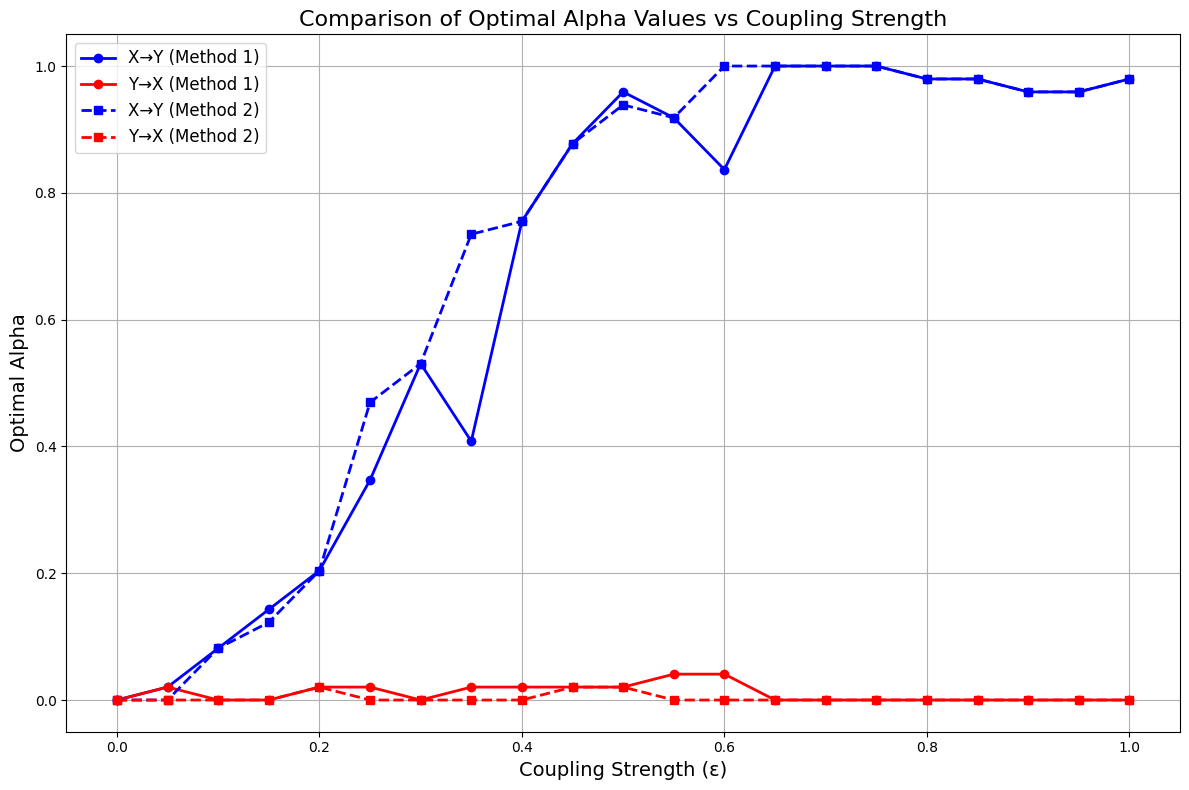

In [15]:
if __name__ == "__main__":
    main()